In [1]:
import copy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Activation
from keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Reshape

## Utility Functions

In [26]:
def norm(x):
    #to normalize sudoku data
    return (x/9)-.5

def denorm(x):
    
    return (x+.5)*9

In [172]:
def sort_data(file): 

    data = pd.read_csv(file) #read into data frame
    inp_raw = data['quizzes'] #sort
    out_raw = data['solutions']
    inp_train = []#allocate memory
    out_train = []
    inp_test = []
    out_test = []
    count = 0
    
    for i in inp_raw: 
        if count < 1000: #exclude 1000 boards for future testing
            x = np.array([int(j) for j in i]).reshape((9,9,1))
            inp_test.append(x) #covert into array
        else:
            x = np.array([int(j) for j in i]).reshape((9,9,1))
            inp_train.append(x)
        count += 1
        
    inp_test = np.array(inp_test)    
    inp_test = norm(inp_test)
    inp_train = np.array(inp_train)  
    inp_train = norm(inp_train) 
    
    count = 0
    
    for i in out_raw:
        if count < 1000:
            y = np.array([int(j) for j in i]).reshape((81,1)) - 1
            out_test.append(y)
        else:
            y = np.array([int(j) for j in i]).reshape((81,1)) - 1
            out_train.append(y)  
        count += 1
    
    out_train = np.array(out_train)
    out_test = np.array(out_test)
    
    del(inp_raw)
    del(out_raw)    

    
    return inp_train, inp_test, out_train, out_test

In [173]:
x_train, x_test, y_train, y_test = sort_data('sudoku.csv')

## Training

In [3]:
%%time
#x_train, x_test, y_train, y_test = get_data('sudoku.csv')
# Dense Model
model = keras.models.Sequential()
#add the layers to the model
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(9,9,1)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))

model.add(Flatten())
model.add(Dense(81*9))
model.add(Reshape((-1, 9)))
model.add(Activation('softmax'))
#optimize, compile, and train model
adam = keras.optimizers.Adam(lr=.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics =['accuracy'])
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

print(history.history.keys())


Epoch 1/10
12375/12375 [==============================] - 603s 49ms/step - loss: 0.4820 - accuracy: 0.7844 - val_loss: 0.3742 - val_accuracy: 0.8183
Epoch 2/10
12375/12375 [==============================] - 602s 49ms/step - loss: 0.3652 - accuracy: 0.8238 - val_loss: 0.3636 - val_accuracy: 0.8244
Epoch 3/10
12375/12375 [==============================] - 618s 50ms/step - loss: 0.3547 - accuracy: 0.8309 - val_loss: 0.3611 - val_accuracy: 0.8264
Epoch 4/10
12375/12375 [==============================] - 615s 50ms/step - loss: 0.3485 - accuracy: 0.8351 - val_loss: 0.3601 - val_accuracy: 0.8273
Epoch 5/10
12375/12375 [==============================] - 618s 50ms/step - loss: 0.3444 - accuracy: 0.8380 - val_loss: 0.3599 - val_accuracy: 0.8276
Epoch 6/10
12375/12375 [==============================] - 621s 50ms/step - loss: 0.3414 - accuracy: 0.8400 - val_loss: 0.3601 - val_accuracy: 0.8276
Epoch 7/10
12375/12375 [==============================] - 616s 50ms/step - loss: 0.3391 - accuracy: 0.8415

In [4]:
model.save('model/dense.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/dense.model\assets


In [6]:
keras.models.load_model('model/dense.model')

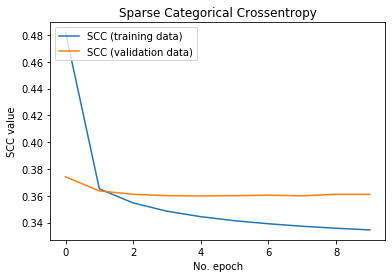

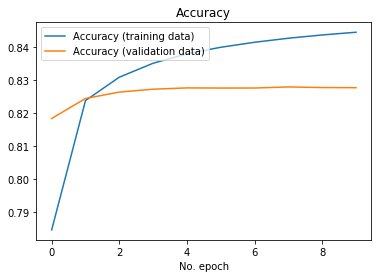

In [7]:
#plotting training metrics
plt.plot(history.history['loss'], label='SCC (training data)')
plt.plot(history.history['val_loss'], label='SCC (validation data)')
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Sparse Categorical Crossentropy')
plt.ylabel('SCC value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


In [ ]:
#Convolutional Model

#model = keras.models.Sequential()

#model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(9,9,1)))
#model.add(BatchNormalization())
#model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2D(128, kernel_size=(1,1), activation='relu', padding='same'))

#model.add(Flatten())
#model.add(Dense(81*9))
#model.add(Reshape((-1, 9)))
#model.add(Activation('softmax'))

## Solving

In [154]:
def first_solve(board):
    #solves based only on initial board state
    inp = copy.copy(board)
    out = model.predict(inp.reshape((1,9,9,1)))  
    out = out.squeeze()
    pred = np.argmax(out, axis=1).reshape((9,9))+1 
    return pred

In [270]:
def iter_solve(board):
    #Solves by using the highest probabilitty prediction for any cell
    #inserts that cell and runs again.
    
    inp = copy.copy(board)
    nonzeros = 0
    while nonzeros < 81:

        nextguess = model.predict(inp.reshape((1,9,9,1)))  
        nextguess = nextguess.squeeze()
        pred = np.argmax(nextguess, axis=1).reshape((9,9))+1 #predicted board state
        conf = np.around(np.max(nextguess, axis=1).reshape((9,9)), 2) #confindence in cell values
        inp = denorm(inp).reshape((9,9))
        nonzeros = np.count_nonzero(inp)
        unsolved = (inp==0) #how many places left     
        conf = conf*unsolved #probabilty of unsolved cells
        index = np.argmax(conf) #index of cell with highest confindn
        row = (index//9)
        col = (index%9) #index on grid
        inp[row][col] = pred[row][col] #insert best guess for this iter
        inp = norm(inp)
    
    return pred

## Testing

In [272]:
def accuracy(inp, out):
    
    correct = 0
    false = 0
    first_error = []
    first_correct = 0
    
    count = 0
        
    for i, inp in enumerate(inp): #loop through input range
        pred = iter_solve(inp) 
        true = out[i].reshape((9,9))+1
        first_pred = first_solve(inp)
        
        if(abs(true - pred).sum()==0):# comapre truth and iterated prediciton
            correct += 1
        else:
            false += 1
            
        first_approx = np.argmax(model.predict(inp.reshape((1,9,9,1))).squeeze(), axis=1).reshape(81,1) 
        count = 0 #compare first approximation and truth
        for j in out[i]:
            error = out[i][j] - first_approx[j]
            if error != 0:
                count +=1
                first_error.append(count)
        #print('First pass errors on board ',i,'is',count)
        if count == 0:
            first_correct += 1
        
    print('Average first approx errors per board are ', np.mean(first_error))
    print('Number of first approx correct games is ', first_correct)
    print('Total false boards after iterative solving is ', false) 
    print('Total correct boards after iterative solving is ',correct)


In [273]:
%%time
accuracy(x_test[:5], y_test[:5])


Average first approx errors per board are  12.875
Number of first approx correct games is  1
Total false boards after iterative solving is  0
Total correct boards after iterative solving is  5
Wall time: 5.66 s


In [262]:
print(iter_solve(x_test[0]).reshape(9,9))
y_test[0].reshape(9,9)+1

[[8 6 4 3 7 1 2 5 9]
 [3 2 5 8 4 9 7 6 1]
 [9 7 1 2 6 5 8 4 3]
 [4 3 6 1 9 2 5 8 7]
 [1 9 8 6 5 7 4 3 2]
 [2 5 7 4 8 3 9 1 6]
 [6 8 9 7 3 4 1 2 5]
 [7 1 3 5 2 8 6 9 4]
 [5 4 2 9 1 6 3 7 8]]


array([[8, 6, 4, 3, 7, 1, 2, 5, 9],
       [3, 2, 5, 8, 4, 9, 7, 6, 1],
       [9, 7, 1, 2, 6, 5, 8, 4, 3],
       [4, 3, 6, 1, 9, 2, 5, 8, 7],
       [1, 9, 8, 6, 5, 7, 4, 3, 2],
       [2, 5, 7, 4, 8, 3, 9, 1, 6],
       [6, 8, 9, 7, 3, 4, 1, 2, 5],
       [7, 1, 3, 5, 2, 8, 6, 9, 4],
       [5, 4, 2, 9, 1, 6, 3, 7, 8]])

In [226]:
b = np.concatenate(x_test[0],axis=0)
b[1]

array([-0.5])

In [211]:
def string_to_board(state):
    #for testing
    state = state.replace('\n', '')
    state = state.replace(' ', '')
    state = np.array([int(j) for j in state]).reshape((9,9,1))
    state = norm(state)
    return state

def solve_board(state):
    #for testing individual boards
    print('Complete Board Guess on first pass')
    state = string_to_board(state)
    out = model.predict(state.reshape((1,9,9,1)))  
    out = out.squeeze()
    pred = np.argmax(out, axis=1).reshape((9,9))+1 
    print(pred)
    state = iter_solve(state)
    print('Best after iterated solving')
    print(state)
    return state


In [212]:
state = '''
          0 8 0 0 3 2 0 0 1
          7 0 3 0 8 0 0 0 2
          5 0 0 0 0 7 0 3 0
          0 5 0 0 0 1 9 7 0
          6 0 0 7 0 9 0 0 8
          0 4 7 2 0 0 0 5 0
          0 2 0 6 0 0 0 0 9
          8 0 0 0 9 0 3 0 5
          3 0 0 8 2 0 0 1 0
      '''
solve_board(state)


Complete Board Guess on first pass
[[4 8 6 9 3 2 5 9 1]
 [7 1 3 1 8 6 5 9 2]
 [5 6 2 1 1 7 8 3 4]
 [2 5 8 4 6 1 9 7 3]
 [6 3 2 7 5 9 1 2 8]
 [9 4 7 2 6 8 1 5 3]
 [1 2 5 6 7 3 8 8 9]
 [8 7 4 1 9 4 3 2 5]
 [3 7 6 8 2 5 6 1 6]]
Best after iterated solving
[[4 8 9 5 3 2 7 6 1]
 [7 1 3 4 8 6 5 9 2]
 [5 6 2 9 1 7 8 3 4]
 [2 5 8 3 4 1 9 7 6]
 [6 3 1 7 5 9 2 4 8]
 [9 4 7 2 6 8 1 5 3]
 [1 2 5 6 7 3 4 8 9]
 [8 7 6 1 9 4 3 2 5]
 [3 9 4 8 2 5 6 1 7]]


array([[4, 8, 9, 5, 3, 2, 7, 6, 1],
       [7, 1, 3, 4, 8, 6, 5, 9, 2],
       [5, 6, 2, 9, 1, 7, 8, 3, 4],
       [2, 5, 8, 3, 4, 1, 9, 7, 6],
       [6, 3, 1, 7, 5, 9, 2, 4, 8],
       [9, 4, 7, 2, 6, 8, 1, 5, 3],
       [1, 2, 5, 6, 7, 3, 4, 8, 9],
       [8, 7, 6, 1, 9, 4, 3, 2, 5],
       [3, 9, 4, 8, 2, 5, 6, 1, 7]], dtype=int64)

In [278]:
game = '''
          0 0 0 0 3 2 0 0 1
          7 0 3 0 8 0 0 0 2
          5 0 0 0 0 7 0 3 0
          0 5 0 0 0 1 9 7 0
          6 0 0 7 0 9 0 0 8
          0 0 7 2 0 0 0 5 0
          0 2 0 6 0 0 0 0 9
          8 0 0 0 0 0 3 0 5
          3 0 0 8 2 0 0 1 0
      '''

game = solve_sudoku(game)

print('solved puzzle:\n')
print(game)
sum(game)

Complete Board Guess on first pass
[[4 8 8 9 3 2 5 8 1]
 [7 1 3 1 8 6 5 9 2]
 [5 8 2 1 9 7 8 3 4]
 [2 5 2 3 6 1 9 7 3]
 [6 3 2 7 5 9 1 2 8]
 [9 8 7 2 6 8 1 5 3]
 [1 2 5 6 7 3 8 8 9]
 [8 7 6 1 9 4 3 2 5]
 [3 7 6 8 2 5 6 1 6]]
Best after iterated solving
solved puzzle:

[[4 6 9 5 3 2 7 8 1]
 [7 1 3 4 8 6 5 9 2]
 [5 8 2 1 9 7 4 3 6]
 [2 5 8 3 6 1 9 7 4]
 [6 3 4 7 5 9 1 2 8]
 [1 9 7 2 4 8 6 5 3]
 [9 2 5 6 7 3 8 4 9]
 [8 7 1 9 2 4 3 6 5]
 [3 4 6 8 2 5 2 1 7]]


array([45, 45, 45, 45, 46, 45, 45, 45, 45], dtype=int64)